### Pruebo : <p>

1.- si con forecast() no necesito reescalar la differencing (habiendo escogido d=1) <font color='green'> RESUELTA </font> <p>
2.- si transformar a logarÃ­tmica compensa por resultados <p>
3.- si hay diferencia entre pasarle a ARIMA la serie original y usar d>0 VS pasarle la serie diferenciada con d=0 <p>
4.- en caso de funcionar con pasarle la serie original y hacer grid search de los parametros pdq, no habria que preocuparse por tratar trend y stationality antes right? <p>
5.- pensar que para anomaly detection quizÃ¡s podrÃ­a usar directamente el residual que me da statsmodel...


In [1]:
'''
Time Series example: https://github.com/aarshayj/Analytics_Vidhya/blob/master/Articles/Time_Series_Analysis/Time_Series_AirPassenger.ipynb
'''

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

data_frame = pd.read_csv('https://raw.githubusercontent.com/aarshayj/analytics_vidhya/master/Articles/Time_Series_Analysis/AirPassengers.csv') 

print(data_frame.head())
print('\n Data Types:')
print(data_frame.dtypes)


Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types:
Month          object
#Passengers     int64
dtype: object


In [2]:
data_frame['Month'] = pd.to_datetime(data_frame['Month'])
#setear como index
data_frame.index = data_frame['Month']
#ver si el index (Month) es tipo 'datetime'
print(data_frame.dtypes)

Month          datetime64[ns]
#Passengers             int64
dtype: object


In [3]:
ts = data_frame
#ahora ya nos sobra la columna 'Month', la cual la hemos aÃ±adido como index del dataframe
ts = ts.drop(['Month'], 1)
ts

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


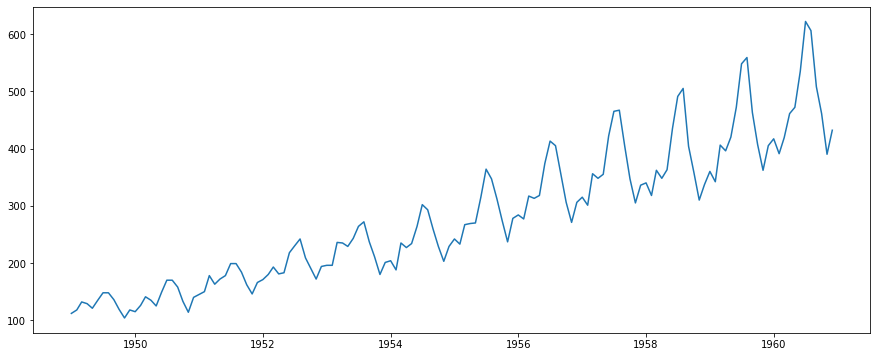

In [4]:
#plot the time series
plt.plot(ts)
plt.show()

In [9]:
#Dickey-Fuller test incluyendo representaciÃ³n de media y SD
from statsmodels.tsa.stattools import adfuller
def test_stationarity_DFULLER(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()  #window = nÃºmero de los Ãºltimos meses escogidos  
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC')   
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
        

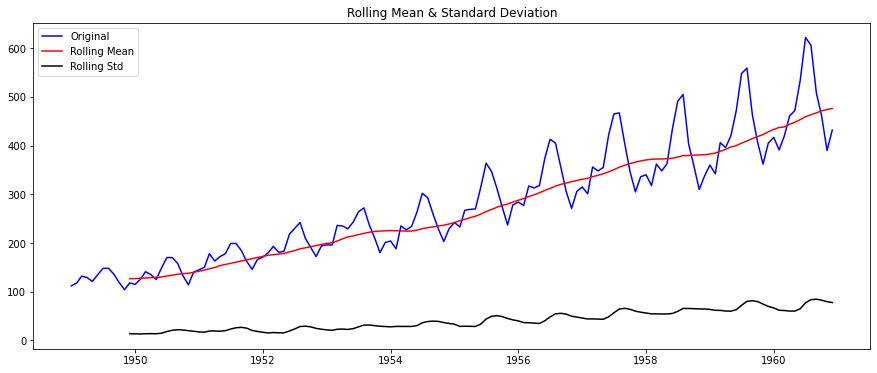

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [10]:
test_stationarity_DFULLER(ts)

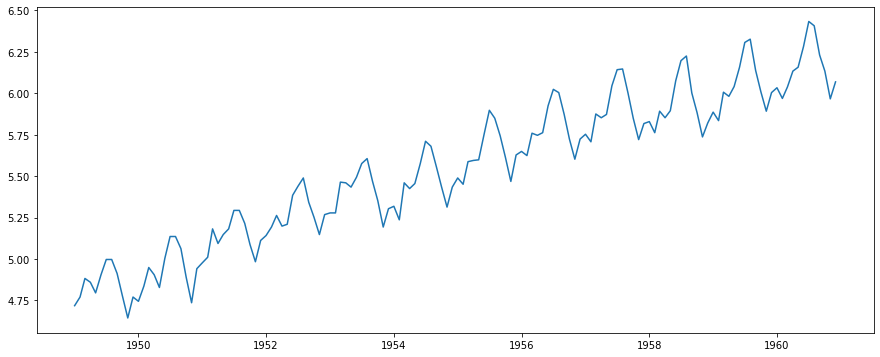

In [11]:
ts_log = np.log(ts)
plt.plot(ts_log)
plt.show()

In [9]:
#source: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/ 
#esto es para calcular el error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

def evaluate_arima_model(ts_values, arima_order):
    size = int(len(ts_values) * 0.60)
    train, test = ts_values[0:size], ts_values[size:len(ts_values)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        #prediction VS expected(test[t])
        predictions.append(yhat)
        #this step is based on 'Walk Forward Validation': 
        #  https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/ 
        # cada nueva prediction va incluyendo en su train set un nuevo elemento de test set
        history.append(test[t])
        #print('expected test value: ', test[t], 'prediction: ', predictions[t])
        
    error = mean_squared_error(test, predictions)
    print('order: ', arima_order, ' error: ',error)
    return error

In [10]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [11]:
import warnings
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

*Para realizar el grid search de los hiper params, pruebo a hacerlo tanto con la ts original como con la ts_log*

In [ ]:
evaluate_models(ts.values, p_values, d_values, q_values)

order:  (0, 0, 0)  error:  30573.3789174
order:  (0, 0, 1)  error:  8924.83995238
order:  (0, 1, 0)  error:  2157.99900616
order:  (0, 1, 1)  error:  1893.41819649
order:  (0, 1, 2)  error:  2067.8313351
order:  (0, 2, 0)  error:  2851.87010422
order:  (0, 2, 1)  error:  2226.30802965
order:  (0, 2, 2)  error:  1941.74294508
order:  (1, 0, 0)  error:  2192.95520139
order:  (1, 0, 1)  error:  1918.18955195
order:  (1, 0, 2)  error:  2003.06982865
order:  (1, 1, 0)  error:  1953.16330888
order:  (1, 1, 1)  error:  2011.3239872
order:  (1, 2, 0)  error:  2816.53574136
order:  (2, 0, 0)  error:  1964.28819344
order:  (2, 0, 1)  error:  1880.85866205
order:  (2, 1, 0)  error:  1899.86588168
order:  (2, 1, 1)  error:  1437.86487782
order:  (2, 1, 2)  error:  1500.24028216
order:  (2, 2, 0)  error:  2708.44507721
order:  (2, 2, 2)  error:  1904.03324758
order:  (4, 0, 0)  error:  1913.06753718
order:  (4, 1, 0)  error:  1795.44630058
order:  (4, 1, 1)  error:  1487.60470737
order:  (4, 1, 2) 

## <font color='green'> Y aquÃ­ es donde veo que hacer la serie estacionaria antes de meterla en el ARIMA object puede ir mejor </font>

fuente: https://machinelearningmastery.com/time-series-data-stationary-python/ 
Does the statsmodel python library require us to convert the series into stationary series before feeding the series to any of the ARMA or ARIMA models ?

REPLY Jason Brownlee:
Ideally, I would. The model can difference to address trends, but I would recommend explicitly pre-processing the data before hand. This will help you better understand your problem/data.

Primero pruebo con <font color='green'>ts_log</font>:

In [ ]:
evaluate_models(ts_log.values, p_values, d_values, q_values)

order:  (0, 0, 0)  error:  0.351258176774
order:  (0, 0, 1)  error:  0.100159711457
order:  (0, 1, 0)  error:  0.01253124272
order:  (0, 1, 1)  error:  0.0115472775429
order:  (0, 1, 2)  error:  0.0130823598825
order:  (0, 2, 0)  error:  0.0179991008315
order:  (0, 2, 1)  error:  0.0129076419707
order:  (1, 0, 0)  error:  0.0129455110196
order:  (1, 0, 1)  error:  0.0119621410103
order:  (1, 1, 0)  error:  0.0117956681386
order:  (1, 1, 1)  error:  0.0119116719832
order:  (1, 1, 2)  error:  0.00973168081023
order:  (1, 2, 0)  error:  0.0169011894308
order:  (2, 0, 0)  error:  0.0121893279257
order:  (2, 0, 1)  error:  0.0113878484389
order:  (2, 1, 0)  error:  0.0116854854218
order:  (2, 1, 1)  error:  0.00919222597548
order:  (2, 2, 0)  error:  0.0160039544993
order:  (2, 2, 2)  error:  0.0113624757269
order:  (4, 0, 0)  error:  0.0120439579876
order:  (4, 1, 0)  error:  0.010424570568
order:  (4, 1, 1)  error:  0.00887662508237
order:  (4, 2, 0)  error:  0.0139786088141
order:  (6, 0

### <font color='green'> Veo claramente errores muy bajos, me quedo con la ts_log por ahora; podrÃ­a incluso probar a diferenciarla, aunque en teorÃ­a eso lo hace ya el param. d... </font>

## 1.- fittedvalues VS forecast(), cuÃ¡l me da las predicciones escaladas correctamente?

In [12]:
def computeCost_as_MSE(X, Y):  #en teorÃ­a anÃ¡logo a usar mean_squared_error de sklearn-metrics
    inner = np.power((X - Y), 2)
    cost = (np.sum(inner))/(len(X))
    return cost

In [12]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")
model = ARIMA(ts_log, order= (10, 2, 0))  
ARIMA_model = model.fit()  

residuals_estimados = np.array(ARIMA_model.fittedvalues)
residuals_reales = np.array(ts_log.values)

mean_squared_error(residuals_estimados, residuals_reales[2:]) #ya que se hace doble differencing

31.033402854211314

In [13]:
#y si pruebo con (8, 1, 1)
model = ARIMA(ts_log, order= (8, 1, 1))  
ARIMA_model = model.fit()  

residuals_estimados = np.array(ARIMA_model.fittedvalues)
residuals_reales = np.array(ts_log.values)

mean_squared_error(residuals_estimados, residuals_reales[1:]) #ya que se hace una differencing


30.868898662086483

In [ ]:
# save model
ARIMA_model.save('ARIMA_model.pkl')

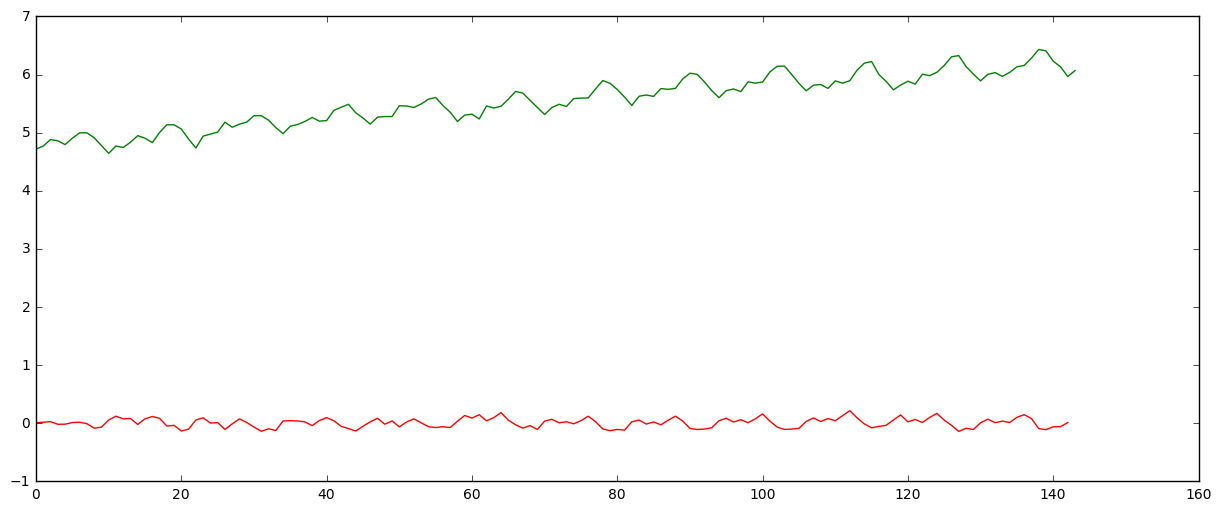

In [14]:
plt.plot(residuals_reales, color = 'green')
plt.plot(residuals_estimados, color='red')
plt.show()

In [15]:
residuals_reales[-6:]

array([[ 6.43294009],
       [ 6.40687999],
       [ 6.23048145],
       [ 6.13339804],
       [ 5.96614674],
       [ 6.06842559]])

In [16]:
residuals_estimados[-6:]

array([ 0.08304822, -0.09101756, -0.10844493, -0.0587837 , -0.05762503,
        0.01341594])

*fitted values no escalados, sino segÃºn se haya hecho o no una differencing*

In [17]:
#haciendo cumsum obtendrÃ© el estimado[-1]
residuals_reales[-2]+residuals_estimados[-1]

array([ 5.97956268])

In [18]:
#y serÃ¡ aprox. igual a:
residuals_reales[-1]

array([ 6.06842559])

### Y ahora pruebo con '.predict()'

In [14]:
from statsmodels.tsa.arima_model import ARIMA
import warnings

series = ts_log['#Passengers'].apply(lambda x: float(x))
arima_order = (8, 1, 1)
size = int(len(series) * 0.80)
train, test = series[0:size], series[size:len(series)]
history = [x for x in train]
predictions = list()
model = ARIMA(history, order=arima_order)
model_fit = model.fit(disp=0)
start_index = len(train)
end_index = start_index + 1
model_forcasting = model_fit.predict(start=start_index, end=end_index)  #model_forcasting = model_fit.forecast() 
yhat = model_forcasting[0]
print(yhat)

-0.008195927053700466


In [15]:
print(train[-1]+yhat)

6.18824820074082


### <font color='green'>conclusiÃ³n</font>: los 'fittedvalues' Y 'predict()' no estÃ¡n escalados segÃºn la serie de entrada, sino acorde a la d (differencing) segÃºn sea 0 o no <p>
    
### ahora pruebo con forecast(), algunos apuntes a tener en cuenta: <p>
    - ARIMA() recibe el time series dataframe (Ã­ndices son las fechas y los correspondientes values) <p>
    - history es igual que train, un dataframe al que vamos aÃ±adiendo (walk forward validation) los Ãºltimos registros <p>
    - test es otro dataframe con fecha-valor al que hay que acceder con iloc si es por Ã­ndices <p>
    - para ver resultados finales en un dataframe, usamos ts_df

In [16]:
#dataframe para almacenar histÃ³rico, test values y forecasts:
ts_df = pd.DataFrame()
ts_df['history'] = history
ts_df['test'] = np.nan
ts_df['forecast'] = np.nan

In [17]:
ts_df.tail()

,history,test,forecast
110,5.891644,NaN,NaN
111,5.852202,NaN,NaN
112,5.894403,NaN,NaN
113,6.075346,NaN,NaN
114,6.196444,NaN,NaN


In [18]:
arima_order = (8, 1, 1)
size = int(len(ts_log) * 0.80)
train, test = ts_log[:size], ts_log[size:]  #ambos son dataframes con filas fecha-valor

history = train.copy()
forecasts = [] 
for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    forecasts.append(yhat)
    #this step is based on 'Walk Forward Validation': 
    #  https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/ 
    # cada nueva prediction va incluyendo en su train set un nuevo elemento de test set
    history = history.append(test.iloc[t])
    
    print('expected test value: ', test.iloc[t]['#Passengers'], '   prediction: ', float(forecasts[t]))
    
    #error = mean_squared_error(test, predictions)
    

/Users/germancabrera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/germancabrera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
expected test value:  6.22455842927536    prediction:  6.18824820074082
/Users/germancabrera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/germancabrera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
expected test value:  6.0014148779611505    prediction:  6.1693263582995

In [25]:
#relleno df
ts_df = pd.DataFrame(columns=['history', 'test', 'forecast'], index=history.index)
ts_df['history'] = history.values
ts_df['test'][-len(test):] = test['#Passengers']
ts_df['forecast'][-len(forecasts):] = [f[0] for f in forecasts]
#seteo las fechas como los index
#ts_df.set_index(history.index, inplace=True)
ts_df

,history,test,forecast
Month,,,
1949-01-01,4.718499,NaN,NaN
1949-02-01,4.770685,NaN,NaN
1949-03-01,4.882802,NaN,NaN
1949-04-01,4.859812,NaN,NaN
1949-05-01,4.795791,NaN,NaN
...,...,...,...
1960-08-01,6.406880,6.40688,6.340865
1960-09-01,6.230481,6.230481,6.301037
1960-10-01,6.133398,6.133398,6.176637


### Los '.forecast()' parecen devolverse en su escala original, con: predicciÃ³n, std y el intervalo de confianza. <font color = 'red'>Incluir tambiÃ©n el intervalo de confianza! </font>


## Confirmo que: <p>
    - forecast() devuelve los datos en la escala original aunque se haga differencing
    - predict() devuelve las predicciones sin reescalar los datos si se ha hecho differencing (como aquÃ­ donde d > 0)
    - con 'fittedvalues' ocurre como con predict(), que no se devuelven en su escala original

## REESCALAR PARA QUITAR ESCALA LOG. Y PLOTEAR LA INFO QUE TENGO EN EL DATAFRAME , CALCULAR SU MSE ETC

In [30]:
#valores no nulos de test (y de forecast)
test_not_nan_mask = pd.isna(ts_df.test)==False
ts_df[test_not_nan_mask]

,history,test,forecast
Month,,,
1958-08-01,6.224558,6.224558,6.188248
1958-09-01,6.001415,6.001415,6.169326
1958-10-01,5.883322,5.883322,5.956535
1958-11-01,5.736572,5.736572,5.856066
1958-12-01,5.820083,5.820083,5.793158
1959-01-01,5.886104,5.886104,5.969081
1959-02-01,5.834811,5.834811,5.909996
1959-03-01,6.006353,6.006353,5.891372
1959-04-01,5.981414,5.981414,6.015558


In [31]:
from sklearn.metrics import mean_squared_error

test_with_values = ts_df.test[pd.isna(ts_df.test)==False]
forecasts_with_values = ts_df.forecast[pd.isna(ts_df.forecast)==False]

mean_squared_error(test_with_values, forecasts_with_values) #(np.array(test), np.array(predictions))


0.006014126111896069

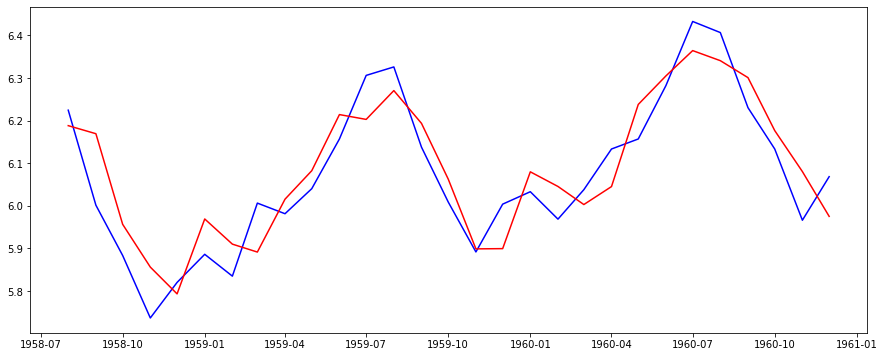

In [32]:
plt.plot(test_with_values, color = 'blue')
plt.plot(forecasts_with_values, color='red')
plt.show()

### Y ahora reescalo con np.exp()

In [33]:
ts_df.history = np.exp(ts_df.history)

In [36]:
ts_df.test = [np.exp(test_val) for test_val in ts_df.test.values]

In [37]:
ts_df.forecast = [np.exp(forecast_val) for forecast_val in ts_df.forecast.values] 

In [38]:
ts_df.tail()

,history,test,forecast
Month,,,
1960-08-01,606.0,606.0,567.286559
1960-09-01,508.0,508.0,545.137074
1960-10-01,461.0,461.0,481.370169
1960-11-01,390.0,390.0,437.201045
1960-12-01,432.0,432.0,393.543161


In [39]:
from sklearn.metrics import mean_squared_error

test_with_values = ts_df.test[pd.isna(ts_df.test)==False]
forecasts_with_values = ts_df.forecast[pd.isna(ts_df.forecast)==False]

mean_squared_error(test_with_values, forecasts_with_values) #(np.array(test), np.array(predictions))


1146.1760008896129

*este error cuadrÃ¡tico medio significa, haciÃ©ndolo la raiz, que de media tenemos un error en torno a 33 pasajeros de diferencia en nuestras predicciones*

In [40]:
np.sqrt(1148.28)

33.88628040962891

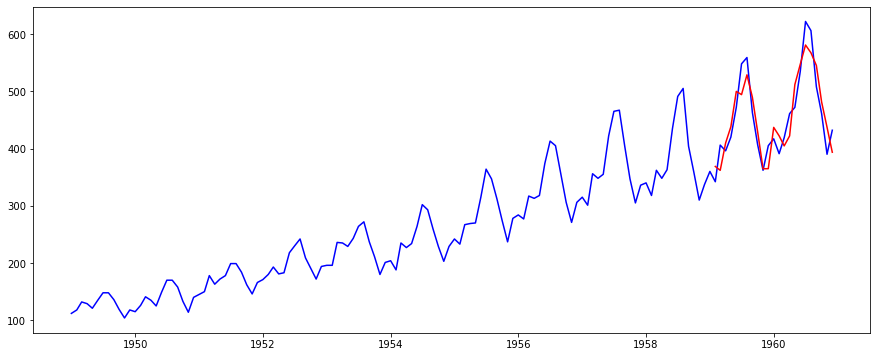

In [41]:
plt.plot(ts_df.history, color = 'blue')
#plt.plot(ts_df.test, color = 'blue')
plt.plot(ts_df.forecast[ts_df.forecast.index > '1959'], color='red')
plt.show()

In [42]:
def computeRMSE(X, Y):  
    inner = np.power((X - Y), 2)
    return np.sqrt(np.sum(inner) / (len(X)))

print('RMSE: ', computeRMSE(ts_df.history[ts_df.history.index > '1959'], ts_df.forecast[ts_df.forecast.index > '1959']))

RMSE:  32.381471790073306


## Esto parece mejorar la predicciÃ³n hecha en 'Time_Series_Forecast_air_passengers-Copy2'

### Siguientes pasos: <p>
    - probar mÃ¡s formas de afinar en ARIMA (pretratado no sÃ³lo con log() por ej) <p>
    - representar el intervalo de confianza, ademÃ¡s de aÃ±adirlo al dataframe
    - compararlo con prophet <p>
    - ir a otros mÃ©todos como LSTM 